<a href="https://colab.research.google.com/github/AlvinChiew/MachineLearning/blob/main/Sklearn_D_Reduction_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Non-Negative Matrix Factorization
- Only works with non-negative data e.g. text, audio, etc
- Components are pointed from origin [ e.g. (0,0) for 2D data ] to the extreme data point(s)
- Order of component is not important but direction/sequence of data is emphasized, e.g. facing direction in image recognition

# Import Modules

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split as split
from joblib import Memory
memory = Memory(cachedir="cache")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='cache'", use "location='cache'" instead.
  import sys


# Data Load & Pre-Process

In [22]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [23]:
# Rationale behind the preprocessing steps may be referred from PCA notebook
filter= np.zeros(people.target.shape, dtype=np.bool)
for p in np.unique(people.target):
    filter[np.where(people.target==p)[0][:50]]=1

X = people.data[filter] / 255     
y = people.target[filter]
X_train, X_test, y_train, y_test = split(X, y, 
                                         stratify=y, random_state=0)

# Train Model

In [25]:
@memory.cache
def nmf_faces(X_train, X_test):
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        nmf = NMF(n_components=n_components, random_state=0)
        nmf.fit(X_train)
        X_test_nmf  = nmf.transform(X_test)
        X_test_back = X_test_nmf @ nmf.components_
        reduced_images.append(X_test_back)
    return reduced_images

In [26]:
# Training takes very long time
reduced_images = nmf_faces(X_train, X_test)

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-68be698f8efa>.nmf_faces...
nmf_faces(array([[0.535948, ..., 0.243137],
       ...,
       [0.043137, ..., 0.596078]], dtype=float32), 
array([[0.237908, ..., 0.269281],
       ...,
       [0.4     , ..., 0.254902]], dtype=float32))
_____________________________________________________nmf_faces - 906.2s, 15.1min


# Observation: # Components

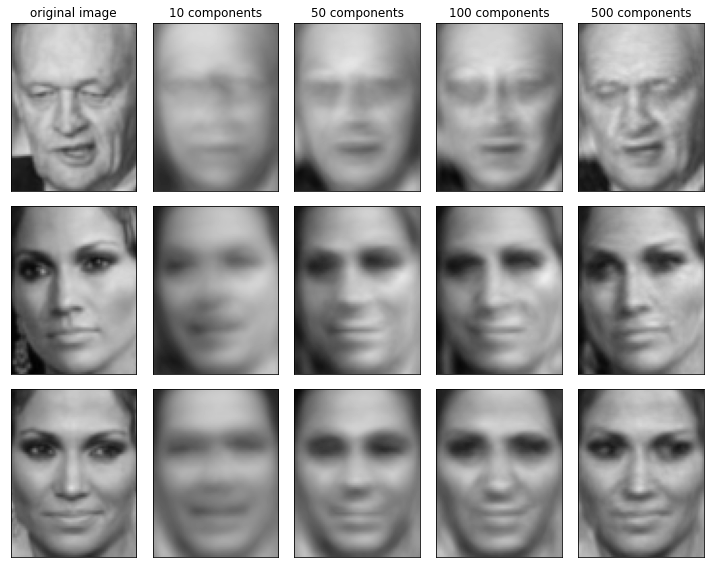

In [27]:
# Illustrate raw image with the corresponding resuled images from NMF in range of [10, 50, 100, 500] components for 3 people
fig,axes=plt.subplots(3,5, figsize=(10,8), 
                     subplot_kw={'xticks':(), 'yticks':()})

for i, ax in enumerate(axes):
    # plot original image
    ax[0].imshow(X_test[i].reshape(people.images[0].shape),
                    vmin=0, vmax=1, cmap='gray')

    # plot the four back-transformed images
    for a, X_test_back in zip(ax[1:], reduced_images):
        a.imshow(X_test_back[i].reshape(people.images[0].shape), 
                    vmin=0, vmax=1, cmap='gray')

    axes[0, 0].set_title("original image")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("%d components" % n_components)
fig.tight_layout()

# Comparing with PCA, especially at 50 and 100 components, facial features are sharper in PCA than NMF
# NMF images seem to be more generally blurred

# Observation: Component breakdown

In [28]:
# To speed up the training, we use 15 components
nmf_15 = NMF(n_components=15, random_state=0)
nmf_15.fit(X_train)
X_train_nmf = nmf_15.transform(X_train)
X_test_nmf = nmf_15.transform(X_test)

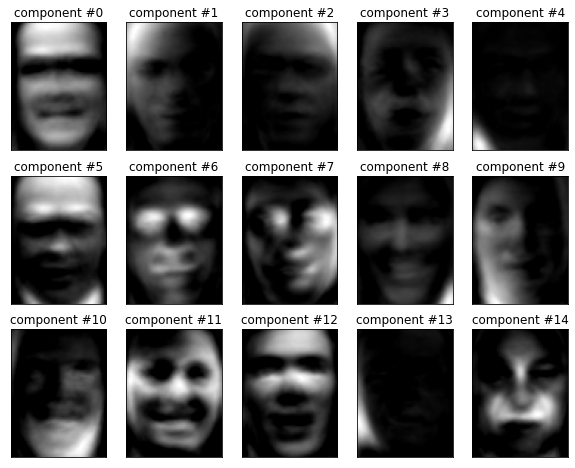

In [30]:
# Show each 15 component from NMF

fig,axes=plt.subplots(3,5, figsize=(10,8), 
                     subplot_kw={'xticks':(), 'yticks':()})
for i, (c, ax) in enumerate(zip(nmf_15.components_, axes.ravel())):
    ax.imshow( c.reshape(people.images[0].shape), cmap='gray')
    ax.set_title('component #%d'%i)

# Seems like NMF is trying to shadow special facial characteristics among people like PCA

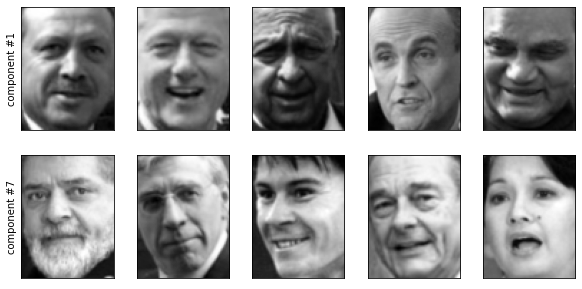

In [46]:
# Peek into component #1 and #11
fig,axes=plt.subplots(2,5, figsize=(10,5),
                     subplot_kw={'xticks':(), 'yticks':()})

compn = 1
idxs = np.argsort( X_train_nmf[:, compn] )[::-1]
for i, (idx, ax) in enumerate( zip(idxs, axes[0]) ):
    ax.imshow( X_train[idx].reshape(people.images[0].shape),cmap='gray')
axes[0][0].set_ylabel('component #%d'%compn, rotation=90)

compn = 7
idxs = np.argsort( X_train_nmf[:, compn] )[::-1]
for i, (idx, ax) in enumerate( zip(idxs, axes[1]) ):
    ax.imshow( X_train[idx].reshape(people.images[0].shape),cmap='gray')
axes[1][0].set_ylabel('component #%d'%compn, rotation=90)

plt.show()

### Patterns ###
# Images with dominant comp #1 captures light gradient from left to right
# Images with dominant comp #7 captures faces facing left direction

# Extra: Methodology Illustration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF

In [2]:
rnd = np.random.RandomState(5)
X_ = rnd.normal(size=(300, 2))
X_blob = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2) + 8   # Add 8 to make sure every point lies in the positive part of the space

In [4]:
X_blob.shape

(300, 2)

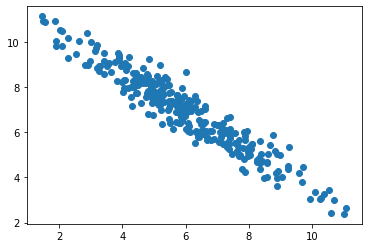

In [5]:
plt.scatter(X_blob[:,0], X_blob[:,1])

(0.0, 12.0)

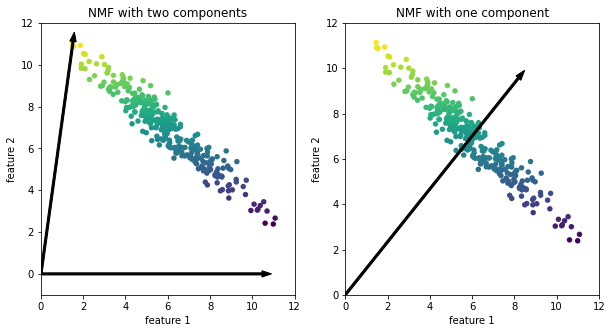

In [19]:
# Illustrate components from NMF

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 2 components
nmf = NMF(random_state=5, n_components=2).fit(X_blob)
axes[0].scatter(X_blob[:, 0], X_blob[:, 1], c=X_nmf[:, 0], 
                linewidths=0, s=30, cmap='viridis')
axes[0].set_xlabel("feature 1")
axes[0].set_ylabel("feature 2")
axes[0].arrow(0, 0, nmf.components_[0, 0], nmf.components_[0, 1], width=.1,
              head_width=.3, color='k')
axes[0].arrow(0, 0, nmf.components_[1, 0], nmf.components_[1, 1], width=.1,
              head_width=.3, color='k')
axes[0].set_title("NMF with two components")
axes[0].set_xlim([0, 12])
axes[0].set_ylim([-1, 12])

# 1 component
nmf = NMF(random_state=0, n_components=1).fit(X_blob)
axes[1].scatter(X_blob[:, 0], X_blob[:, 1], c=X_nmf[:, 0], 
                linewidths=0, s=30, cmap='viridis')
axes[1].set_xlabel("feature 1")
axes[1].set_ylabel("feature 2")
axes[1].arrow(0, 0, nmf.components_[0, 0], nmf.components_[0, 1], width=.1,
              head_width=.3, color='k')
axes[1].set_title("NMF with one component")
axes[1].set_xlim([0, 12])
axes[1].set_ylim([0, 12])